本次以英雄联盟对局胜负预测任务为基础，要求实现决策树算法相关细节，加深对算法的理解，并了解做机器学习任务的大致流程。

### 任务介绍
英雄联盟（League of Legends，LoL）是一个多人在线竞技游戏，由拳头游戏（Riot Games）公司出品。在游戏中，每位玩家控制一位有独特技能的英雄，红蓝两支队伍各有五位玩家进行对战，目标是摧毁对方的基地水晶。水晶有多座防御塔保护，通常需要先摧毁一些防御塔再摧毁水晶。玩家所控制的英雄起初非常弱，需要不断击杀小兵、野怪和对方英雄来获得金币、经验。经验可以提升英雄等级和技能等级，金币可以用来购买装备提升攻击、防御等属性。对战过程中一般没有己方单位在附近的地点是没有视野的，即无法看到对面单位，双方可以通过使用守卫来监视某个地点，洞察对面走向、制定战术。
本数据集来自[Kaggle](https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min)，包含了9879场钻一到大师段位的单双排对局，对局双方几乎是同一水平。每条数据是前10分钟的对局情况，每支队伍有19个特征，红蓝双方共38个特征。这些特征包括英雄击杀、死亡，金钱、经验、等级情况等等。一局游戏一般会持续30至40分钟，但是实际前10分钟的局面很大程度上影响了之后胜负的走向。作为最成功的电子竞技游戏之一，对局数据、选手数据的量化与研究具有重要意义，可以启发游戏将来的发展和改进。

本任务是希望同学们依据注释的要求，对代码中空缺部分进行填写，**完成决策树模型的详细实现**，根据已有的对局前10分钟特征信息，预测最后获胜方是蓝色方还是红色方，了解执行一个**机器学习任务的大致流程**，并**提交代码和实验报告**。第一次作业也是一个机器学习小实验的例子，之后的作业可能不再提供预处理等流程代码，由同学们自己设计实验完成代码编写。

### 导入工具包
pandas是数据分析和处理常用的工具包，非常适合处理行列表格数据。numpy是数学运算工具包，支持高效的矩阵、向量运算。sklearn是机器学习常用工具包，包括了一些已经实现好的简单模型和一些常用数据处理方法、评价指标等函数。

In [1]:
from collections import Counter
import pandas as pd # 数据处理
pd.set_option('display.max_columns', None)
import numpy as np # 数学运算
from sklearn.model_selection import train_test_split, cross_validate # 划分数据集函数
from sklearn.metrics import accuracy_score # 准确率函数
import seaborn as sns
import matplotlib.pyplot as plt
RANDOM_SEED = 2020 # 固定随机种子

### 读入数据
假设数据文件放在`./data/`目录下，标准的csv文件可以用pandas里的`read_csv()`函数直接读入。文件共有40列，38个特征（红蓝方各19），1个标签列（blueWins），和一个对局标号（gameId）。对局标号不是标签也不是特征，可以舍去。

In [2]:
csv_data = './data/high_diamond_ranked_10min.csv' # 数据路径
data_df = pd.read_csv(csv_data, sep=',') # 读入csv文件为pandas的DataFrame
data_df = data_df.drop(columns='gameId') # 舍去对局标号列

In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   blueWins                      9879 non-null   int64  
 1   blueWardsPlaced               9879 non-null   int64  
 2   blueWardsDestroyed            9879 non-null   int64  
 3   blueFirstBlood                9879 non-null   int64  
 4   blueKills                     9879 non-null   int64  
 5   blueDeaths                    9879 non-null   int64  
 6   blueAssists                   9879 non-null   int64  
 7   blueEliteMonsters             9879 non-null   int64  
 8   blueDragons                   9879 non-null   int64  
 9   blueHeralds                   9879 non-null   int64  
 10  blueTowersDestroyed           9879 non-null   int64  
 11  blueTotalGold                 9879 non-null   int64  
 12  blueAvgLevel                  9879 non-null   float64
 13  blu

###  数据概览
对于一个机器学习问题，在拿到任务和数据后，首先需要观察数据的情况，比如我们可以通过`.iloc[0]`取出数据的第一行并输出。不难看出每个特征都存成了float64浮点数，该对局蓝色方开局10分钟有小优势。同时也可以发现有些特征列是重复冗余的，比如blueGoldDiff表示蓝色队金币优势，redGoldDiff表示红色方金币优势，这两个特征是完全对称的互为相反数。blueCSPerMin是蓝色方每分钟击杀小兵数，它乘10就是10分钟所有小兵击杀数blueTotalMinionsKilled。在之后的特征处理过程中可以考虑去除这些冗余特征。
另外，pandas有非常方便的`describe()`函数，可以直接通过DataFrame进行调用，可以展示每一列数据的一些统计信息，对数据分布情况有大致了解，比如blueKills蓝色方击杀英雄数在前十分钟的平均数是6.14、方差为2.93，中位数是6，百分之五十以上的对局中该特征在4-8之间，等等。

In [4]:
print(data_df.iloc[0]) # 输出第一行数据
data_df.describe() # 每列特征的简单统计信息

blueWins                            0.0
blueWardsPlaced                    28.0
blueWardsDestroyed                  2.0
blueFirstBlood                      1.0
blueKills                           9.0
blueDeaths                          6.0
blueAssists                        11.0
blueEliteMonsters                   0.0
blueDragons                         0.0
blueHeralds                         0.0
blueTowersDestroyed                 0.0
blueTotalGold                   17210.0
blueAvgLevel                        6.6
blueTotalExperience             17039.0
blueTotalMinionsKilled            195.0
blueTotalJungleMinionsKilled       36.0
blueGoldDiff                      643.0
blueExperienceDiff                 -8.0
blueCSPerMin                       19.5
blueGoldPerMin                   1721.0
redWardsPlaced                     15.0
redWardsDestroyed                   6.0
redFirstBlood                       0.0
redKills                            6.0
redDeaths                           9.0


blueWins  blueWardsPlaced  blueWardsDestroyed  blueFirstBlood  \
count  9879.000000      9879.000000         9879.000000     9879.000000   
mean      0.499038        22.288288            2.824881        0.504808   
std       0.500024        18.019177            2.174998        0.500002   
min       0.000000         5.000000            0.000000        0.000000   
25%       0.000000        14.000000            1.000000        0.000000   
50%       0.000000        16.000000            3.000000        1.000000   
75%       1.000000        20.000000            4.000000        1.000000   
max       1.000000       250.000000           27.000000        1.000000   

         blueKills   blueDeaths  blueAssists  blueEliteMonsters  blueDragons  \
count  9879.000000  9879.000000  9879.000000        9879.000000  9879.000000   
mean      6.183925     6.137666     6.645106           0.549954     0.361980   
std       3.011028     2.933818     4.064520           0.625527     0.480597   
min       0.000000     0.000000     0.000000           0.000000     0.000000   
25%       4.000000     4.000000     4.000000           0.000000     0.000000   
50%       6.000000     6.000000     6.000000           0.000000     0.000000   
75%       8.000000     8.000000     9.000000           1.000000     1.000000   
max      22.000000    22.000000    29.000000           2.000000     1.000000   

       blueHeralds  blueTowersDestroyed  blueTotalGold  blueAvgLevel  \
count  9879.000000          9879.000000    9879.000000   9879.000000   
mean      0.187974             0.051422   16503.455512      6.916004   
std       0.390712             0.244369    1535.446636      0.305146   
min       0.000000             0.000000   10730.000000      4.600000   
25%       0.000000             0.000000   15415.500000      6.800000   
50%       0.000000             0.000000   16398.000000      7.000000   
75%       0.000000             0.000000   17459.000000      7.200000   
max       1.000000             4.000000   23701.000000      8.000000   

       blueTotalExperience  blueTotalMinionsKilled  \
count          9879.000000             9879.000000   
mean          17928.110133              216.699565   
std            1200.523764               21.858437   
min           10098.000000               90.000000   
25%           17168.000000              202.000000   
50%           17951.000000              218.000000   
75%           18724.000000              232.000000   
max           22224.000000              283.000000   

       blueTotalJungleMinionsKilled  blueGoldDiff  blueExperienceDiff  \
count                   9879.000000   9879.000000         9879.000000   
mean                      50.509667     14.414111          -33.620306   
std                        9.898282   2453.349179         1920.370438   
min                        0.000000 -10830.000000        -9333.000000   
25%                       44.000000  -1585.500000        -1290.500000   
50%                       50.000000     14.000000          -28.000000   
75%                       56.000000   1596.000000         1212.000000   
max                       92.000000  11467.000000         8348.000000   

       blueCSPerMin  blueGoldPerMin  redWardsPlaced  redWardsDestroyed  \
count   9879.000000     9879.000000     9879.000000        9879.000000   
mean      21.669956     1650.345551       22.367952           2.723150   
std        2.185844      153.544664       18.457427           2.138356   
min        9.000000     1073.000000        6.000000           0.000000   
25%       20.200000     1541.550000       14.000000           1.000000   
50%       21.800000     1639.800000       16.000000           2.000000   
75%       23.200000     1745.900000       20.000000           4.000000   
max       28.300000     2370.100000      276.000000          24.000000   

       redFirstBlood     redKills    redDeaths   redAssists  redEliteMonsters  \
count    9879.000000  9879.000000  9879.000000  9879.000000       9879.

### 增删特征
传统的机器学习模型大部分都是基于特征的，因此特征工程是机器学习中非常重要的一步。有时构造一个好的特征比改进一个模型带来的提升更大。这里简单展示一些特征处理的例子。首先，上面提到，特征列中有些特征信息是完全冗余的，会给模型带来不必要的计算量，可以去除。其次，相比于红蓝双方击杀、助攻的绝对值，可能双方击杀英雄的差值更能体现出当前对战的局势。因此，我们可以构造红蓝双方对应特征的差值。数据文件中已有的差值是金币差GoldDiff和经验差ExperienceDiff，实际上每个对应特征都可以构造这样的差值特征。

In [5]:
drop_features = ['blueGoldDiff', 'redGoldDiff', 
                 'blueExperienceDiff', 'redExperienceDiff', 
                 'blueCSPerMin', 'redCSPerMin', 
                 'blueGoldPerMin', 'redGoldPerMin'] # 需要舍去的特征列
df = data_df.drop(columns=drop_features) # 舍去特征列
info_names = [c[3:] for c in df.columns if c.startswith('red')] # 取出要作差值的特征名字（除去red前缀）
for info in info_names: # 对于每个特征名字
    df['br' + info] = df['blue' + info] - df['red' + info] # 构造一个新的特征，由蓝色特征减去红色特征，前缀为br
# 其中FirstBlood为首次击杀最多有一只队伍能获得，brFirstBlood=1为蓝，0为没有产生，-1为红
df = df.drop(columns=['blueFirstBlood', 'redFirstBlood']) # 原有的FirstBlood可删除

In [6]:
df.head()

blueWins  blueWardsPlaced  blueWardsDestroyed  blueKills  blueDeaths  \
0         0               28                   2          9           6   
1         0               12                   1          5           5   
2         0               15                   0          7          11   
3         0               43                   1          4           5   
4         0               75                   4          6           6   

   blueAssists  blueEliteMonsters  blueDragons  blueHeralds  \
0           11                  0            0            0   
1            5                  0            0            0   
2            4                  1            1            0   
3            5                  1            0            1   
4            6                  0            0            0   

   blueTowersDestroyed  blueTotalGold  blueAvgLevel  blueTotalExperience  \
0                    0          17210           6.6                17039   
1                    0          14712           6.6                16265   
2                    0          16113           6.4                16221   
3                    0          15157           7.0                17954   
4                    0          16400           7.0                18543   

   blueTotalMinionsKilled  blueTotalJungleMinionsKilled  redWardsPlaced  \
0                     195                            36              15   
1                     174                            43              12   
2                     186                            46              15   
3                     201                            55              15   
4                     210                            57              17   

   redWardsDestroyed  redKills  redDeaths  redAssists  redEliteMonsters  \
0                  6         6          9           8                 0   
1                  1         5          5           2                 2   
2                  3        11          7          14                 0   
3                  2         5          4          10                 0   
4                  2         6          6           7                 1   

   redDragons  redHeralds  redTowersDestroyed  redTotalGold  redAvgLevel  \
0           0           0                   0         16567          6.8   
1           1           1                   1         17620          6.8   
2           0           0                   0         17285          6.8   
3           0           0                   0         16478          7.0   
4           1           0                   0         17404          7.0   

   redTotalExperience  redTotalMinionsKilled  redTotalJungleMinionsKilled  \
0               17047                    197                           55   
1               17438                    240                           52   
2               17254                    203                           28   
3               17961                    235                           47   
4               18313                    225                           67   

   brWardsPlaced  brWardsDestroyed  brFirstBlood  brKills  brDeaths  \
0             13                -4             1        3        -3   
1              0                 0            -1        0         0   
2              0                -3            -1       -4         4   
3             28                -1            -1       -1         1   
4             58                 2            -1        0         0   

   brAssists  brEliteMonsters  brDragons  brHeralds  brTowersDestroyed  \
0          3                0          0          0                  0   
1          3               -2         -1         -1                 -1   
2        -10                1          1          0                  0   
3         -5                1          0          1                  0   
4         -1               -1         -1          0                  0   

   brTotalGold  brAvgL

In [7]:
info_names

['WardsPlaced',
 'WardsDestroyed',
 'FirstBlood',
 'Kills',
 'Deaths',
 'Assists',
 'EliteMonsters',
 'Dragons',
 'Heralds',
 'TowersDestroyed',
 'TotalGold',
 'AvgLevel',
 'TotalExperience',
 'TotalMinionsKilled',
 'TotalJungleMinionsKilled']

### 特征离散化
决策树ID3算法一般是基于离散特征的，本例中存在很多连续的数值特征，例如队伍金币。直接应用该算法每个值当作一个该特征的一个取值可能造成严重的过拟合，因此需要对特征进行离散化，即将一定范围内的值映射成一个值，例如对用户年龄特征，将0-10映射到0，11-18映射到1，19-25映射到2，25-30映射到3，等等类似，然后在决策树构建时使用映射后的值计算信息增益。

***本小节要求实现特征离散化，请补全相关代码***

In [8]:
discrete_df = df.copy() # 先复制一份数据
cols = [ 'redKills', 'redEliteMonsters', 'redDragons','redTotalMinionsKilled',
       'redTotalJungleMinionsKilled', 'redHeralds',
         'blueTotalMinionsKilled']
df_clean = discrete_df.drop(cols, axis = 1)
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   blueWins                      9879 non-null   int64  
 1   blueWardsPlaced               9879 non-null   int64  
 2   blueWardsDestroyed            9879 non-null   int64  
 3   blueKills                     9879 non-null   int64  
 4   blueDeaths                    9879 non-null   int64  
 5   blueAssists                   9879 non-null   int64  
 6   blueEliteMonsters             9879 non-null   int64  
 7   blueDragons                   9879 non-null   int64  
 8   blueHeralds                   9879 non-null   int64  
 9   blueTowersDestroyed           9879 non-null   int64  
 10  blueTotalGold                 9879 non-null   int64  
 11  blueAvgLevel                  9879 non-null   float64
 12  blueTotalExperience           9879 non-null   int64  
 13  blu

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1209: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


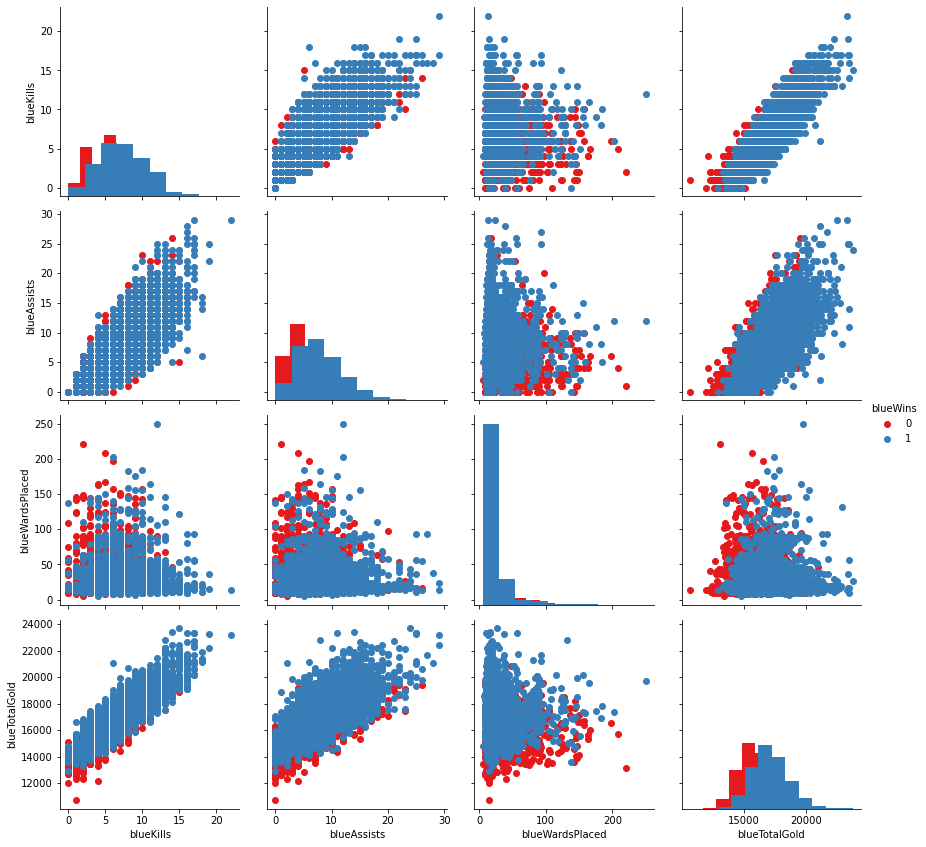

In [9]:
g = sns.PairGrid(data=df_clean, vars=['blueKills', 'blueAssists', 'blueWardsPlaced', 'blueTotalGold'], hue='blueWins', size=3, palette='Set1')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

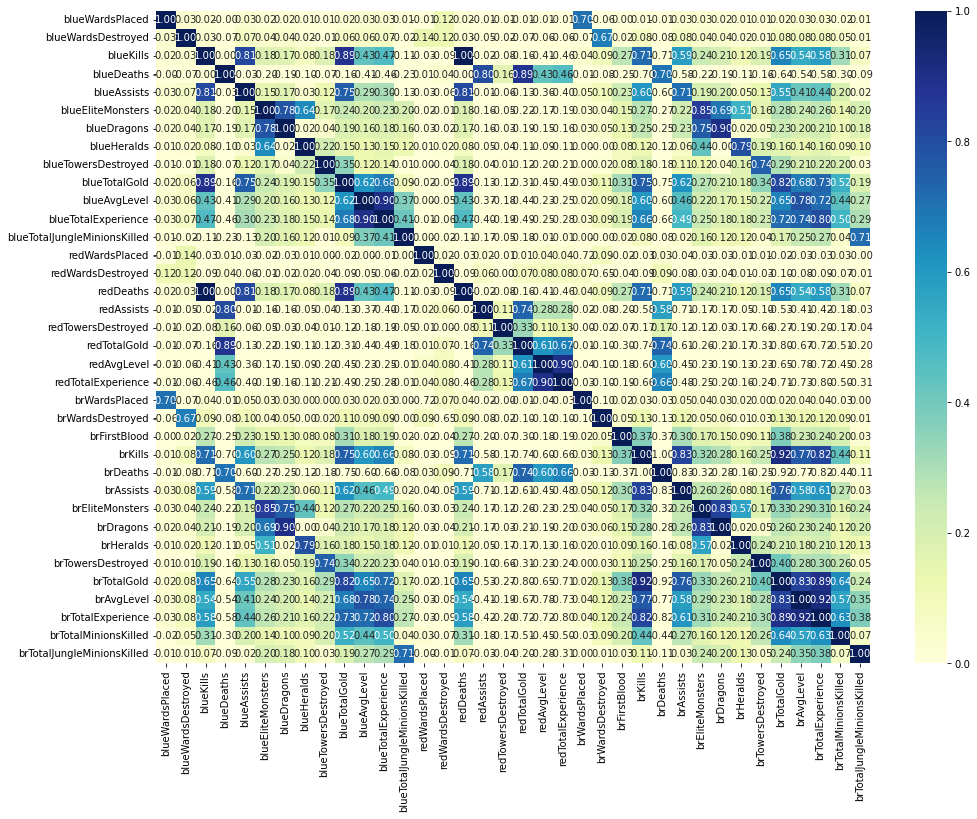

In [10]:
plt.figure(figsize=(16, 12))
sns.heatmap(df_clean.drop('blueWins', axis=1).corr(), cmap='YlGnBu', annot=True, fmt='.2f', vmin=0);

In [11]:
cols = ['blueAvgLevel', 'redWardsPlaced', 'redWardsDestroyed', 'redDeaths', 'redAssists', 'redTowersDestroyed',
       'redTotalExperience', 'redTotalGold', 'redAvgLevel']
df_clean = df_clean.drop(cols, axis=1)

In [12]:
corr_list = df_clean[df_clean.columns[1:]].apply(lambda x: x.corr(df_clean['blueWins']))
cols = []
for col in corr_list.index:
    if (corr_list[col]>0.2 or corr_list[col]<-0.2):
        cols.append(col)
cols

['blueKills',
 'blueDeaths',
 'blueAssists',
 'blueEliteMonsters',
 'blueDragons',
 'blueTotalGold',
 'blueTotalExperience',
 'brFirstBlood',
 'brKills',
 'brDeaths',
 'brAssists',
 'brEliteMonsters',
 'brDragons',
 'brTotalGold',
 'brAvgLevel',
 'brTotalExperience',
 'brTotalMinionsKilled']

In [13]:
df_clean = df_clean[cols]
df_clean.head()

blueKills  blueDeaths  blueAssists  blueEliteMonsters  blueDragons  \
0          9           6           11                  0            0   
1          5           5            5                  0            0   
2          7          11            4                  1            1   
3          4           5            5                  1            0   
4          6           6            6                  0            0   

   blueTotalGold  blueTotalExperience  brFirstBlood  brKills  brDeaths  \
0          17210                17039             1        3        -3   
1          14712                16265            -1        0         0   
2          16113                16221            -1       -4         4   
3          15157                17954            -1       -1         1   
4          16400                18543            -1        0         0   

   brAssists  brEliteMonsters  brDragons  brTotalGold  brAvgLevel  \
0          3                0          0          643        -0.2   
1          3               -2         -1        -2908        -0.2   
2        -10                1          1        -1172        -0.4   
3         -5                1          0        -1321         0.0   
4         -1               -1         -1        -1004         0.0   

   brTotalExperience  brTotalMinionsKilled  
0                 -8                    -2  
1              -1173                   -66  
2              -1033                   -17  
3                 -7                   -34  
4                230                   -15

### 数据集准备
构建机器学习模型前要构建训练和测试的数据集。在本例中首先需要分开标签和特征，标签是不能作为模型的输入特征的，就好比作业和试卷答案不能在做题和考试前就告诉学生。测试一个模型在一个任务上的效果至少需要训练集和测试集，训练集用来训练模型的参数，好比学生做作业获得知识，测试集用来测试模型效果，好比期末考试考察学生学习情况。测试集的样本不应该出现在训练集中，否则会造成模型效果估计偏高，好比考试时出的题如果是作业题中出现过的，会造成考试分数不能准确衡量学生的学习情况，估计值偏高。划分训练集和测试集有多种方法，下面首先介绍的是随机取一部分如20%作测试集，剩下作训练集。sklearn提供了相关工具函数`train_test_split`。sklearn的输入输出一般为numpy的array矩阵，需要先将pandas的DataFrame取出为numpy的array矩阵。

In [14]:
all_y = discrete_df['blueWins'].values # 所有标签数据
feature_names = discrete_df.columns[1:] # 所有特征的名称
all_x = discrete_df[feature_names].values # 所有原始特征值，pandas的DataFrame.values取出为numpy的array矩阵

# 划分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=RANDOM_SEED)
all_y.shape, all_x.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape # 输出数据行列信息

((9879,), (9879, 43), (7903, 43), (1976, 43), (7903,), (1976,))

''

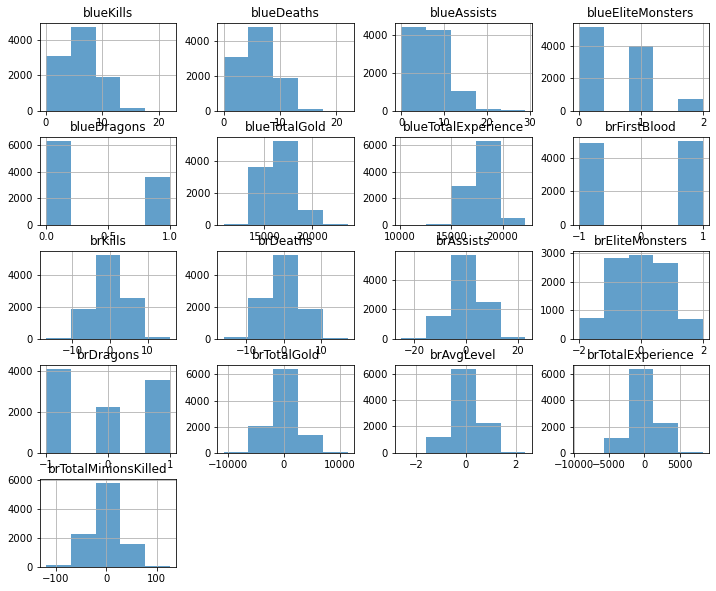

In [15]:
df_clean.hist(alpha = 0.7, figsize=(12,10), bins=5);""

###  决策树模型的实现
***本小节要求实现决策树模型，请补全算法代码***

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
X = df_clean
y = df['blueWins']
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



from sklearn import tree
from sklearn.model_selection import GridSearchCV

tree = tree.DecisionTreeClassifier()

# search the best params
grid = {'min_samples_split': [5, 10, 20, 50, 100]},

clf_tree = GridSearchCV(tree, grid, cv=5)
clf_tree.fit(X_train, y_train)

pred_tree = clf_tree.predict(X_test)

# get the accuracy score
acc_tree = accuracy_score(pred_tree, y_test)
print(acc_tree)

0.6887651821862348


#### Random Forests

In [ ]:
# fit the model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

# search the best params
grid = {'n_estimators':[100,200,300,400,500], 'max_depth': [2, 5, 10]}

clf_rf = GridSearchCV(rf, grid, cv=5)
clf_rf.fit(X_train, y_train)

pred_rf = clf_rf.predict(X_test)
# get the accuracy score
acc_rf = accuracy_score(pred_rf, y_test)
print(acc_rf)

### 模型调优
第一次模型测试结果可能不够好，可以先检查调试代码是否有bug，再尝试调整参数或者优化计算方法。

### 总结
一个完整的机器学习任务包括：确定任务、数据分析、特征工程、数据集划分、模型设计、模型训练和效果测试、结果分析和调优等多个阶段，本案例以英雄联盟游戏胜负预测任务为例，给出了每个阶段的一些简单例子，帮助大家入门机器学习，希望大家有所收获！

In [ ]:
data_dict = {'DT': [acc_tree], 'Random Forest': [acc_rf]}
df_c = pd.DataFrame.from_dict(data_dict, orient='index', columns=['Accuracy Score'])
print(df_c)

In [ ]:
X = df_clean
y = df['blueWins']

from sklearn import preprocessing 
X = preprocessing.StandardScaler().fit_transform(X)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X)
print(pca.explained_variance_ratio_)